## Install Albumentations and Change Directory

In [ ]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

     |████████████████████████████████| 81kB 5.9MB/s 
     |████████████████████████████████| 38.2MB 77kB/s 
     |████████████████████████████████| 952kB 47.1MB/s 
albumentations==0.5.2 is successfully installed


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/DD2424/

/content/drive/MyDrive/DD2424


# Imports

In [ ]:
import dataset
import utils
import model
import numpy as np

import torch
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm.notebook import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from model import UNET
from utils import (load_checkpoint, save_checkpoint, get_loaders)
import matplotlib.pyplot as plt
from torch.autograd import Variable
torch.cuda.empty_cache()

# Training Functions

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1e-4):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return dice_loss

In [ ]:
def train_fn(loader, model, optimizer, loss_fn, scaler, epoch, num_epochs, acc_max):
    
    loss_vector = []
    acc_vector = []

    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            
            # ------------------ Loss --------------------------------------#
            # Binary Cross Entropy Loss
            bce = nn.BCEWithLogitsLoss()
            bce_loss = bce(predictions, targets)

            # Dice Loss
            dice_loss = loss_fn(predictions, targets)

             # Dice + BCE Loss
            loss = dice_loss + bce_loss
            
            loss_vector.append(loss.item())


            # ------------------ Accuracy ----------------------------------#
            acc = 1 - dice_loss
            acc_vector.append(acc.item())

            if acc > acc_max:
              acc_max = acc
              print("...saving model - Acc: ", acc_max)
              torch.save(model.state_dict(), "adam_bce_dice.pth")

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item(), acc=acc.item())
        
    return loss_vector, acc_vector, acc_max

In [ ]:
def train(train_loader, model, optimizer, loss_fn, num_epochs, device):
    
        scaler = torch.cuda.amp.GradScaler()

        loss_epoch = []
        acc_epoch = []

        acc_max = 0.7

        for epoch in range(num_epochs):

            loss_vector, acc_vector, acc_max = train_fn(train_loader, model, optimizer, loss_fn, scaler, epoch, num_epochs, acc_max)
            
            # ------------------ Loss --------------------------------------#
            mean_loss = sum(loss_vector)/len(loss_vector)
            loss_epoch.append(mean_loss)

            
            # ------------------ Accuracy ----------------------------------#
            mean_acc = sum(acc_vector)/len(acc_vector)
            acc_epoch.append(mean_acc)

            torch.cuda.empty_cache()


        return loss_epoch, acc_epoch

# Main

In [ ]:
torch.cuda.empty_cache()
        
# Hyperparameters etc.
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8
NUM_EPOCHS = 50
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
TRAIN_IMG_DIR = "Full_no_black/train_images/"
TRAIN_MASK_DIR = "Full_no_black/train_masks/"
VAL_IMG_DIR = "Full_no_black/val_images/"
VAL_MASK_DIR = "Full_no_black/val_masks/"
    
train_transform = A.Compose(
            [
                A.Rotate(limit=35, p=1.0),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.1),
                A.Normalize(
                    mean=[0.0, 0.0, 0.0],
                    std=[1.0, 1.0, 1.0],
                    max_pixel_value=255.0,
                ),
                ToTensorV2(),
            ],
        )

val_transforms = A.Compose(
            [
                A.Normalize(
                    mean=[0.0, 0.0, 0.0],
                    std=[1.0, 1.0, 1.0],
                    max_pixel_value=255.0,
                ),
                ToTensorV2(),
            ],
        )

train_loader, val_loader = get_loaders(
            TRAIN_IMG_DIR,
            TRAIN_MASK_DIR,
            VAL_IMG_DIR,
            VAL_MASK_DIR,
            BATCH_SIZE,
            train_transform,
            val_transforms,
            NUM_WORKERS,
            PIN_MEMORY,
        )

if LOAD_MODEL:
    load_checkpoint(torch.load("adam_bce_dice.pth"), model)

model = UNET(in_channels=3, out_channels=1).to(DEVICE)
loss_fn = DiceBCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Train
loss_epoch, acc_epoch = train(train_loader, model, optimizer, loss_fn, num_epochs=NUM_EPOCHS, device=DEVICE)

...saving model - ACDC:  tensor(0.7119, device='cuda:0', grad_fn=<RsubBackward1>)



...saving model - ACDC:  tensor(0.7318, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.7469, device='cuda:0', grad_fn=<RsubBackward1>)



...saving model - ACDC:  tensor(0.7102, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.7246, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.7298, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.7664, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.7771, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.7854, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.7954, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.7960, device='cuda:0', grad_fn=<RsubBackward1>)



...saving model - ACDC:  tensor(0.7171, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.7455, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.7576, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.7827, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.7850, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.7933, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.7993, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.8007, device='cuda:0', grad_fn=<RsubBackward1>)



...saving model - ACDC:  tensor(0.7535, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.7790, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.8008, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.8024, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.8112, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.8173, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.8318, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.8344, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.8448, device='cuda:0', grad_fn=<RsubBackward1>)



...saving model - ACDC:  tensor(0.7542, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.8154, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.8350, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.8388, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.8478, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.8686, device='cuda:0', grad_fn=<RsubBackward1>)



...saving model - ACDC:  tensor(0.8095, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.8769, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.8781, device='cuda:0', grad_fn=<RsubBackward1>)



...saving model - ACDC:  tensor(0.8642, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.8953, device='cuda:0', grad_fn=<RsubBackward1>)



...saving model - ACDC:  tensor(0.8583, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.8609, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.8826, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.8968, device='cuda:0', grad_fn=<RsubBackward1>)



...saving model - ACDC:  tensor(0.8206, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.8869, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.8908, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9007, device='cuda:0', grad_fn=<RsubBackward1>)



...saving model - ACDC:  tensor(0.8349, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.8741, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.8842, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9004, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9023, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9056, device='cuda:0', grad_fn=<RsubBackward1>)



...saving model - ACDC:  tensor(0.8824, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.8938, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9084, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9142, device='cuda:0', grad_fn=<RsubBackward1>)



...saving model - ACDC:  tensor(0.8175, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9003, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9134, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9265, device='cuda:0', grad_fn=<RsubBackward1>)



...saving model - ACDC:  tensor(0.8760, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.8867, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.8984, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9028, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9166, device='cuda:0', grad_fn=<RsubBackward1>)



...saving model - ACDC:  tensor(0.8760, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.8804, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.8825, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.8901, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.8911, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9027, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9227, device='cuda:0', grad_fn=<RsubBackward1>)



...saving model - ACDC:  tensor(0.8701, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9069, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9175, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9195, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9205, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9230, device='cuda:0', grad_fn=<RsubBackward1>)



...saving model - ACDC:  tensor(0.9172, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9262, device='cuda:0', grad_fn=<RsubBackward1>)



...saving model - ACDC:  tensor(0.9006, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9232, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9358, device='cuda:0', grad_fn=<RsubBackward1>)



...saving model - ACDC:  tensor(0.9159, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9159, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9191, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9274, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9315, device='cuda:0', grad_fn=<RsubBackward1>)



...saving model - ACDC:  tensor(0.8810, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9118, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9163, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9193, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9204, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9233, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9270, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9370, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9398, device='cuda:0', grad_fn=<RsubBackward1>)



...saving model - ACDC:  tensor(0.8669, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.8769, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9206, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9211, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9416, device='cuda:0', grad_fn=<RsubBackward1>)



...saving model - ACDC:  tensor(0.8615, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.8876, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.8980, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9099, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9161, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9210, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9263, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9320, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9419, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9425, device='cuda:0', grad_fn=<RsubBackward1>)



...saving model - ACDC:  tensor(0.9266, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9359, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9362, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9363, device='cuda:0', grad_fn=<RsubBackward1>)



...saving model - ACDC:  tensor(0.8784, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9086, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9114, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9220, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9267, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9270, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9307, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9425, device='cuda:0', grad_fn=<RsubBackward1>)



...saving model - ACDC:  tensor(0.8811, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.8998, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9038, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9063, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9217, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9267, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9333, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9366, device='cuda:0', grad_fn=<RsubBackward1>)



...saving model - ACDC:  tensor(0.8736, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.8775, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9009, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9019, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9084, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9256, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9308, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9394, device='cuda:0', grad_fn=<RsubBackward1>)



...saving model - ACDC:  tensor(0.9113, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9220, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9228, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9447, device='cuda:0', grad_fn=<RsubBackward1>)



...saving model - ACDC:  tensor(0.9159, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9284, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9335, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9482, device='cuda:0', grad_fn=<RsubBackward1>)



...saving model - ACDC:  tensor(0.8589, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9185, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9225, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9320, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9361, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9467, device='cuda:0', grad_fn=<RsubBackward1>)



...saving model - ACDC:  tensor(0.9136, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9156, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9226, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9326, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9406, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9480, device='cuda:0', grad_fn=<RsubBackward1>)



...saving model - ACDC:  tensor(0.9026, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9064, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9392, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9394, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9424, device='cuda:0', grad_fn=<RsubBackward1>)



...saving model - ACDC:  tensor(0.8706, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9380, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9405, device='cuda:0', grad_fn=<RsubBackward1>)



...saving model - ACDC:  tensor(0.8896, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9068, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9179, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9195, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9430, device='cuda:0', grad_fn=<RsubBackward1>)



...saving model - ACDC:  tensor(0.8191, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.8217, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9104, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9276, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9349, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9351, device='cuda:0', grad_fn=<RsubBackward1>)



...saving model - ACDC:  tensor(0.8980, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.8984, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9198, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9303, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9365, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9371, device='cuda:0', grad_fn=<RsubBackward1>)



...saving model - ACDC:  tensor(0.9122, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9306, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9342, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9359, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9381, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9521, device='cuda:0', grad_fn=<RsubBackward1>)



...saving model - ACDC:  tensor(0.9191, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9373, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9448, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9491, device='cuda:0', grad_fn=<RsubBackward1>)



...saving model - ACDC:  tensor(0.9285, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9332, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9471, device='cuda:0', grad_fn=<RsubBackward1>)



...saving model - ACDC:  tensor(0.8961, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.8987, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9332, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9382, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9387, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9391, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9445, device='cuda:0', grad_fn=<RsubBackward1>)



...saving model - ACDC:  tensor(0.9005, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9070, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9212, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9290, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9305, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9456, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9496, device='cuda:0', grad_fn=<RsubBackward1>)



...saving model - ACDC:  tensor(0.9099, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9125, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9397, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9435, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9467, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9477, device='cuda:0', grad_fn=<RsubBackward1>)



...saving model - ACDC:  tensor(0.8912, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9405, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9465, device='cuda:0', grad_fn=<RsubBackward1>)



...saving model - ACDC:  tensor(0.8595, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9316, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9370, device='cuda:0', grad_fn=<RsubBackward1>)
...saving model - ACDC:  tensor(0.9447, device='cuda:0', grad_fn=<RsubBackward1>)



# Plot Training Loss

In [ ]:
def plot_train_loss(loss_epoch):
    plt.plot(loss_epoch)

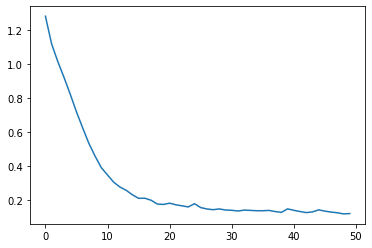

In [ ]:
plot_train_loss(loss_epoch)

In [ ]:
def plot_acc_scores(acc_epoch):
    plt.plot(acc_epoch)

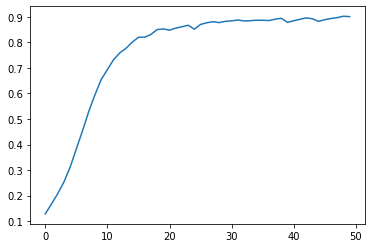

In [ ]:
plot_acc_scores(acc_epoch)

# Print Predictions

In [ ]:
def visualize_segmentation(model, data_loader, num_samples=5, device='cuda'):
     #visualize segmentation on unseen samples
    fig, axs = plt.subplots(num_samples, 3, figsize=(30,30))

    for ax, col in zip(axs[0], ['MRI','MRI with Mask', 'MRI with Prediciton']):
        ax.set_title(col)

    index = 0
    for i,batch in enumerate(data_loader):

            img = batch[0].to(device)
            msk = batch[1].to(device)

            output = model(img)
            
            for j in range(batch[0].size()[0]): #iterate over batchsize
                
                axs[index,0].imshow(np.transpose(img[j].detach().cpu().numpy(), (1,2,0)).astype(np.float32), cmap='bone', interpolation='none')
                axs[index,1].imshow(np.transpose(img[j].detach().cpu().numpy(), (1,2,0)).astype(np.float32), cmap='bone', interpolation='none')
                axs[index,1].imshow(torch.squeeze(msk[j]).detach().cpu().numpy(), cmap='Reds', interpolation='none', alpha=0.5)
                axs[index,2].imshow(np.transpose(img[j].detach().cpu().numpy(), (1,2,0)).astype(np.float32), cmap='bone', interpolation='none')
                axs[index,2].imshow(torch.squeeze(output[j]).detach().cpu().numpy(), cmap='Reds', interpolation='none', alpha=0.5)

                
                index += 1
                    
                if index >= num_samples:

                    break 
                    
            if index >= num_samples:
                  
                    break 
            
    plt.tight_layout()

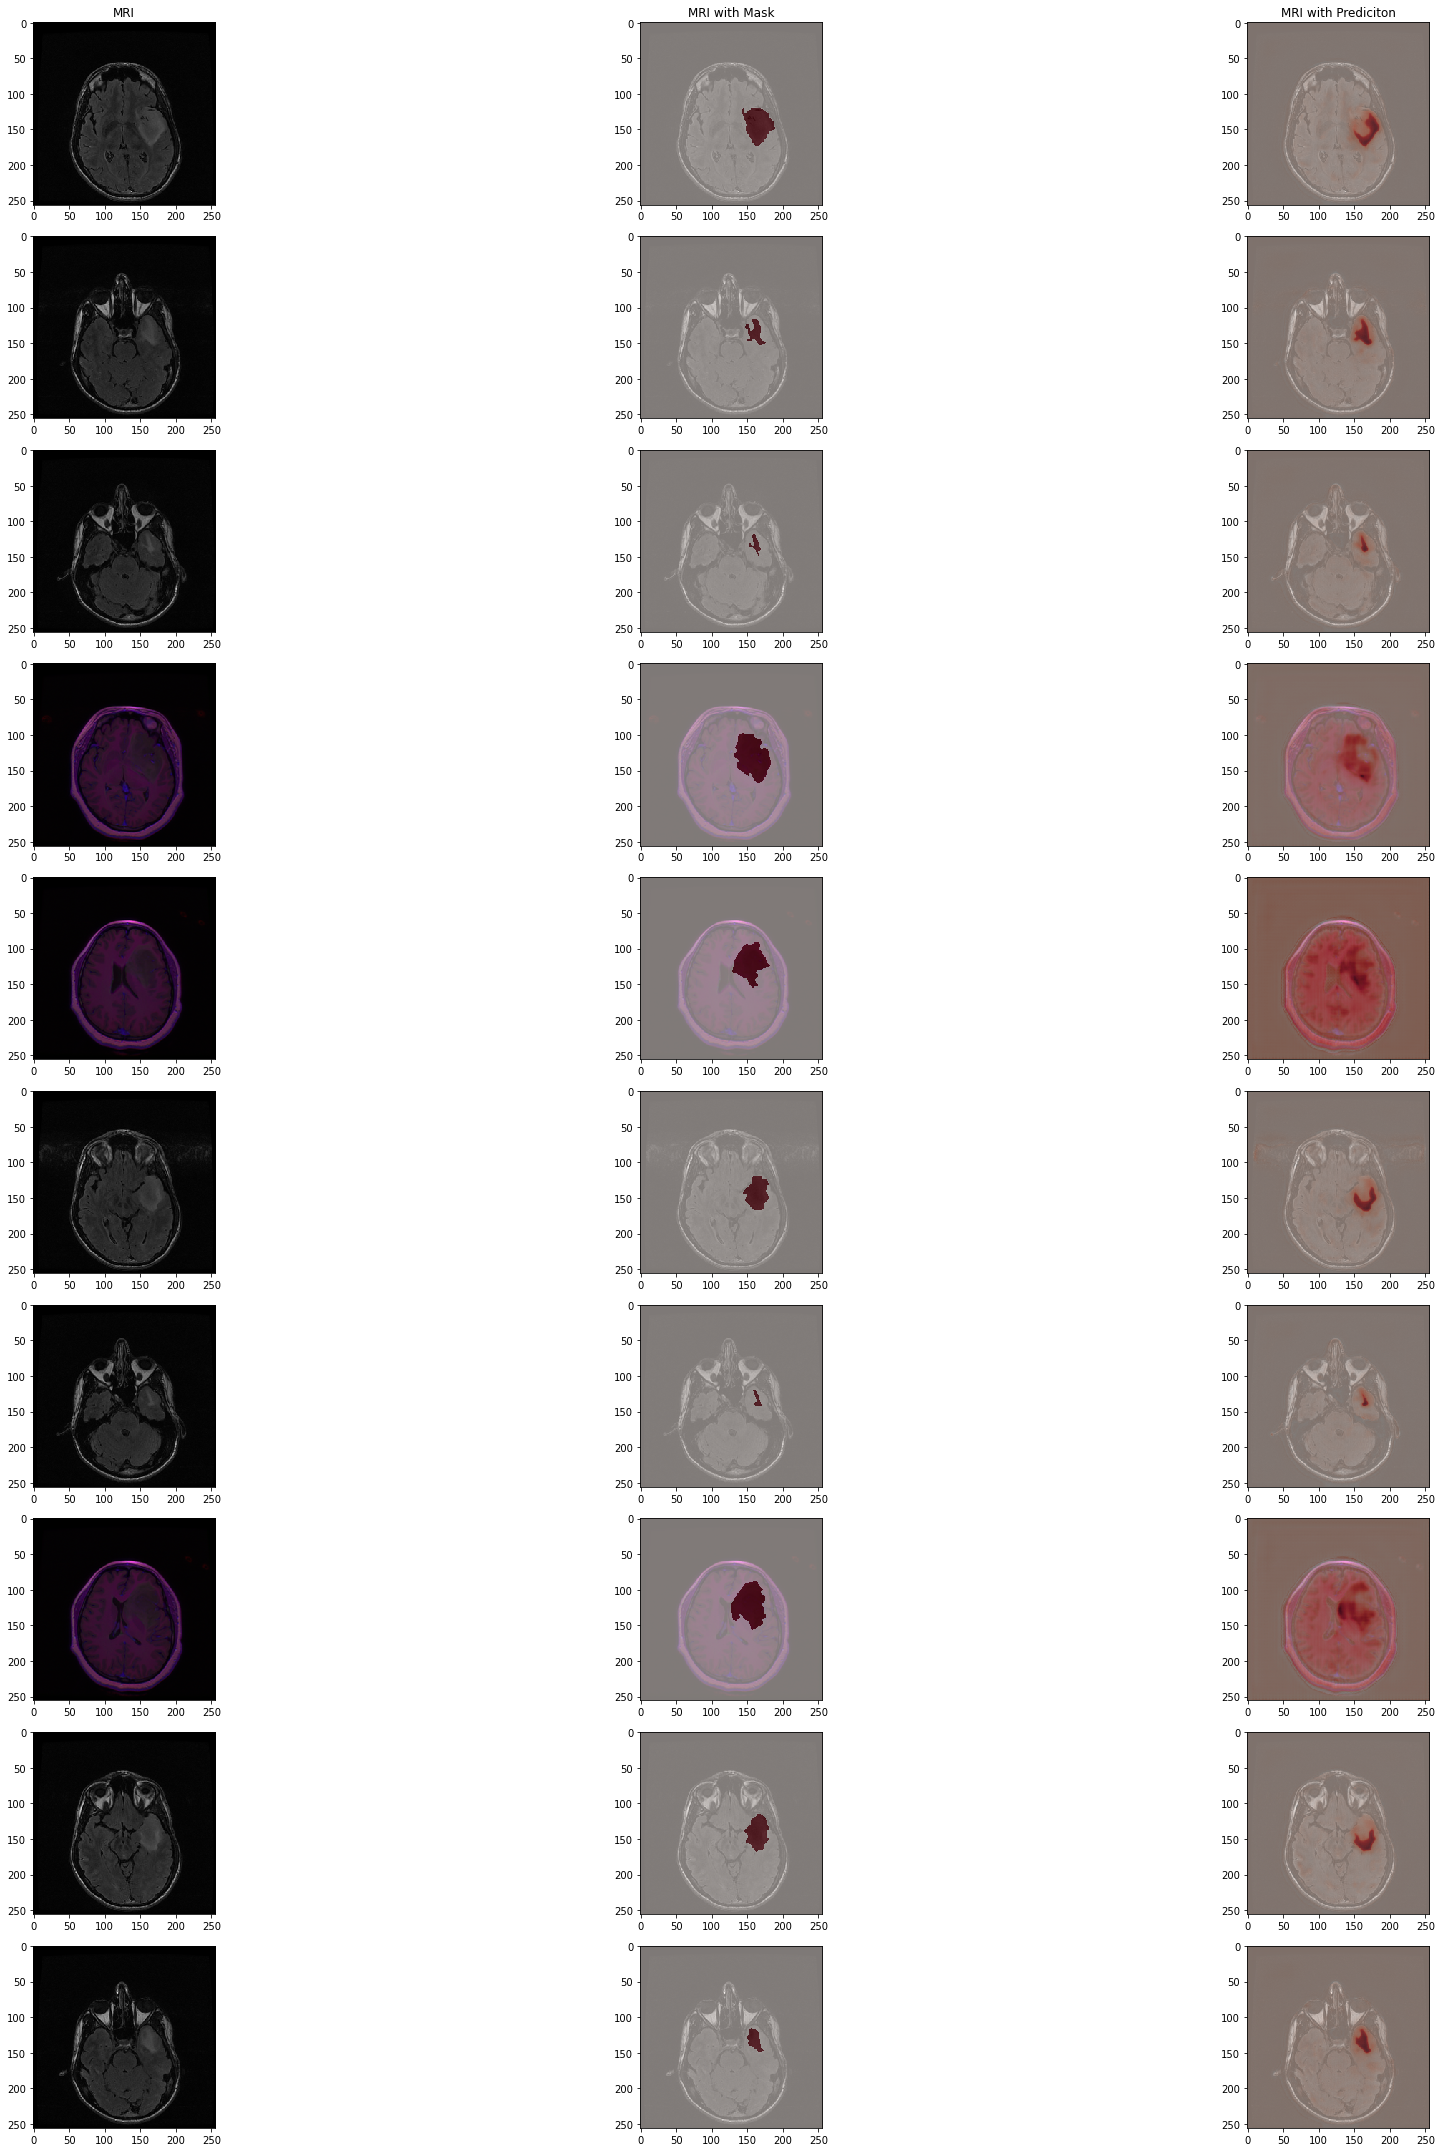

In [ ]:
torch.cuda.empty_cache()
visualize_segmentation(model, val_loader, num_samples=10, device='cuda')

# Test Accuracy

In [ ]:
def Dice_score(val_loader, model, device="cuda"):
    loop = tqdm(val_loader)
    acc_vector = []
    model.eval()
    
    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)
        
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)
            acc_vector.append(1-loss.item())

    

    return sum(acc_vector)/len(acc_vector)

In [ ]:
def testLoad(val_loader, model, optimizer, loss_fn, device):

    scaler = torch.cuda.amp.GradScaler()

    val_loop = tqdm(val_loader)

    model.eval()

    for batch_idx, (data, targets) in enumerate(val_loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            
            predictions = model(data)

            # ------------------ Accuracy------------------------------------#
            # Dice Score
            test_dice_score = Dice_score(val_loader, model, device=DEVICE)
            print(test_dice_score)
            break

    return True

In [ ]:
torch.cuda.empty_cache()
testLoad(val_loader, model, optimizer, loss_fn, device=DEVICE)


0.7380732950710115


True